# Conversational RAG Example

In [ ]:
!pip install burr[start] sf-hamilton[visualization] openai 

In [1]:
# Importing the necessary libraries
import pprint
from typing import Tuple
from hamilton import dataflows, driver
import burr.core
from burr.core import ApplicationBuilder, State, default, expr
from burr.core.action import action
from burr.tracking import LocalTrackingClient
import uuid

# Load your "chain" or conversational RAG "pipeline"

We use Hamilton here. But you could use LangChain, etc., or forgo them and write your own code.

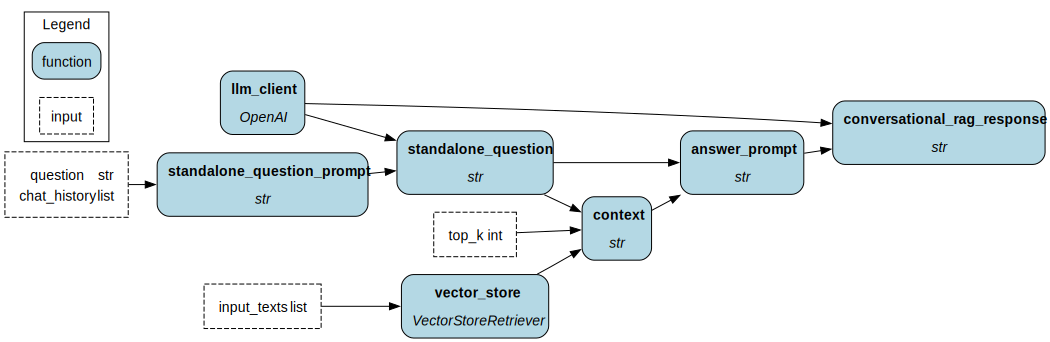

In [2]:
# Loads Hamilton DAG
conversational_rag = dataflows.import_module("conversational_rag")
conversational_rag_driver = (
    driver.Builder()
    .with_config({})  # replace with configuration as appropriate
    .with_modules(conversational_rag)
    .build()
)
conversational_rag_driver.display_all_functions()

# Create the actions that will constitute our application

We will use the functional (vs class) approach to declaring actions here. 

In [3]:
@action(
    reads=["question", "chat_history"],
    writes=["chat_history"],
)
def ai_converse(state: State, vector_store: object) -> Tuple[dict, State]:
    """AI conversing step. Uses Hamilton to execute the conversational pipeline."""
    result = conversational_rag_driver.execute(
        ["conversational_rag_response"],
        inputs={
            "question": state["question"],
            "chat_history": state["chat_history"],
        },
        # we use overrides here because we want to pass in the vector store
        overrides={
            "vector_store": vector_store,
        }
    )
    new_history = f"AI: {result['conversational_rag_response']}"
    return result, state.append(chat_history=new_history)


@action(
    reads=[],
    writes=["question", "chat_history"],
)
def human_converse(state: State, user_question: str) -> Tuple[dict, State]:
    """Human converse step -- make sure we get input, and store it as state."""
    state = state.update(question=user_question).append(chat_history=f"Human: {user_question}")
    return {"question": user_question}, state

# Add a hook to print the steps -- optional but shows that Burr is pluggable

In [4]:
from burr.core import Action
from burr.lifecycle import PostRunStepHook, PreRunStepHook

class PrintStepHook(PostRunStepHook, PreRunStepHook):
    """Custom hook to print the action/result after each step."""

    def pre_run_step(self, action: Action, **future_kwargs):
        if action.name == "ai_converse":
            print("🤔 AI is thinking...")
        if action.name == "human_converse":
            print("⏳Processing input from user...")

    def post_run_step(self, *, state: "State", action: Action, result: dict, **future_kwargs):
        if action.name == "human_converse":
            print("🎙💬", result["question"], "\n")
        if action.name == "ai_converse":
            print("🤖💬", result["conversational_rag_response"], "\n")

# Create the application

We now create the application, which is a collection of actions, and then set the transitions between the actions based on values in State.

We also intialize initial values etc to populate the application with.

In [5]:
# what we will do RAG over.
initial_documents = [
    "harrison worked at kensho",
    "stefan worked at Stitch Fix",
    "stefan likes tacos",
    "elijah worked at TwoSigma",
    "elijah likes mango",
    "stefan used to work at IBM",
    "elijah likes to go biking",
    "stefan likes to bake sourdough",
]
# bootstrap the vector store;
vector_store = conversational_rag_driver.execute(
    ["vector_store"],
    inputs={"input_texts": initial_documents})["vector_store"]
# what we will initialize the application with
initial_state = {
    "question": "",
    "chat_history": [],
}

app_id = str(uuid.uuid4())
app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=app_id, partition_key="sample_user")
    # initialize the state
    .with_state(**initial_state)
    # say what the initial action is
    .with_entrypoint("human_converse")
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(project="demo:conversational-rag")
    # build the application
    .build()
)

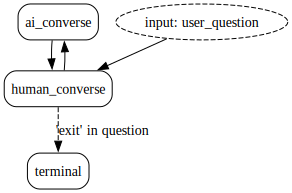

In [6]:
# let's visualize what we have
app.visualize(include_conditions=True)

# Let's run the app. 

Let's run it a step at a time.

In [7]:
app.reset_to_entrypoint() # reset the app to the entrypoint
user_question = input("Ask something (or type exit to quit): ")
previous_action, result, state = app.step(
    inputs={"user_question": user_question},
)
print(f"Ran action {previous_action.name} with result:\n {pprint.pformat(result)} \n and state:\n {pprint.pformat(state.get_all())}")

Ask something (or type exit to quit):  Who is Stefan? Please answer in English.


⏳Processing input from user...
🎙💬 Who is Stefan? Please answer in English. 

Ran action human_converse with result:
 {'question': 'Who is Stefan? Please answer in English.'} 
 and state:
 {'__PRIOR_STEP': 'human_converse',
 '__SEQUENCE_ID': 0,
 'chat_history': ['Human: Who is Stefan? Please answer in English.'],
 'question': 'Who is Stefan? Please answer in English.'}


In [8]:
# now let's run the AI conversational step
previous_action, result, state = app.step()
print(f"Ran action {previous_action.name} with result:\n {pprint.pformat(result)} \n and state:\n {pprint.pformat(state.get_all())}")

🤔 AI is thinking...
🤖💬 Stefan is someone who likes tacos, used to work at IBM, worked at Stitch Fix, and likes to bake sourdough. 

Ran action ai_converse with result:
 {'conversational_rag_response': 'Stefan is someone who likes tacos, used to '
                                'work at IBM, worked at Stitch Fix, and likes '
                                'to bake sourdough.'} 
 and state:
 {'__PRIOR_STEP': 'ai_converse',
 '__SEQUENCE_ID': 1,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.'],
 'question': 'Who is Stefan? Please answer in English.'}


# Let's now run the app to completion

You could do the above for each action. Or you could tell the app to run until certain
actions/conditions are met.

In [9]:
print(f"Running RAG with initial state:\n {pprint.pformat(app.state.get_all())}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break

Running RAG with initial state:
 {'__PRIOR_STEP': 'ai_converse',
 '__SEQUENCE_ID': 1,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.'],
 'question': 'Who is Stefan? Please answer in English.'}


Ask something (or type exit to quit):  where does Elijah work?


⏳Processing input from user...
🎙💬 where does Elijah work? 

🤔 AI is thinking...
🤖💬 Elijah works at TwoSigma. 



Ask something (or type exit to quit):  what should I buy him to eat?


⏳Processing input from user...
🎙💬 what should I buy him to eat? 

🤔 AI is thinking...
🤖💬 You should buy Elijah some mangoes to eat. 



Ask something (or type exit to quit):  What type of mangoes does he like?


⏳Processing input from user...
🎙💬 What type of mangoes does he like? 

🤔 AI is thinking...
🤖💬 It is not specified what type of mangoes Elijah likes in the given context. 



Ask something (or type exit to quit):  Who is the most likely person to like corn & beans?


⏳Processing input from user...
🎙💬 Who is the most likely person to like corn & beans? 

🤔 AI is thinking...
🤖💬 Stefan is most likely to enjoy eating corn and beans. 



Ask something (or type exit to quit):  Why?


⏳Processing input from user...
🎙💬 Why? 

🤔 AI is thinking...
🤖💬 There is no clear indication in the context provided that Stefan would be the most likely person to enjoy eating corn and beans. The information suggests that Stefan enjoys tacos and baking sourdough, but there is nothing regarding his preferences for corn and beans specifically. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context provided '
                  'that Stefan would be the most like

# Reloading from prior state

Burr makes it easy to reload from a prior state. In this example we'll just use what is logged to the tracker to "go back in time" and reload the application to that state. 

This is useful for debugging, building the application itself, etc.

There are two ways to load prior state:
1. Load the state outside the Burr Application. i.e. pass it in as initial state.
2. Use the ApplicationBuilder .initialize_from() method. You can optionally "fork" or continue an existing application this way.

The difference between them, is that the first method is more flexible and gives you total control.
The second method gives you two options: 
(a) to explicitly "fork" i.e. create a new application from a certain point in time from an existing application_id.
(b) allows you to "pick up where you left off" with an existing application_id, e.g. in the case of a crash, or if you wanted to start from the last conversation with a user, and continue.

Below we show how to do the first method. Then after that the second method, to show how to fork the conversation,
as well as pick up the prior conversation from where it left off.  


In [10]:
# set up for rewinding to a prior state -- loading it in as initial state
prior_app_id = app_id
last_sequence_id = app.sequence_id
rewind_to_sequence_id = last_sequence_id - 2
new_app_id = str(uuid.uuid4())

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
persisted_state = tracker.load(partition_key="sample_user", 
                               app_id=prior_app_id, 
                               sequence_id=rewind_to_sequence_id)
state_values = persisted_state['state'].get_all()
print(f"Loaded state from app_id:{prior_app_id}, "
      f"sequence_id:{rewind_to_sequence_id}::\n "
      f"{pprint.pformat(state_values)}")

Loaded state from app_id:63fce731-8cc8-4de0-b8dc-0a5f1a057a11, sequence_id:11::
 {'__SEQUENCE_ID': 11,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context pr

In [11]:
# build our other application using the state we just loaded.
other_app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=new_app_id, partition_key="sample_user")
    # set state to prior state
    .with_state(**persisted_state["state"].get_all())
    # say where we want to start
    .with_entrypoint("human_converse")
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

In [12]:
# We can now change test, debug, etc. from this prior state.
print(f"Running RAG with loaded state:\n {pprint.pformat(state_values)}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = other_app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action and previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break



Running RAG with loaded state:
 {'__SEQUENCE_ID': 11,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context provided '
                  'that Stefan would be 

Ask something (or type exit to quit):  does Harrison like pizza?


⏳Processing input from user...
🎙💬 does Harrison like pizza? 

🤔 AI is thinking...
🤖💬 There is no information provided in the context to determine whether Harrison likes pizza or not. 



Ask something (or type exit to quit):  Who should I take to a Mexican restaurant?


⏳Processing input from user...
🎙💬 Who should I take to a Mexican restaurant? 

🤔 AI is thinking...
🤖💬 Stefan 



Ask something (or type exit to quit):  Who worked at TwoSigma?


⏳Processing input from user...
🎙💬 Who worked at TwoSigma? 

🤔 AI is thinking...
🤖💬 Elijah worked at TwoSigma. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context provided '
                  'that Stefan would be the most like

## Picking up where we left off from a prior conversation with `initialize_from()`

In [13]:
# Now let's show how to use the ApplicationBuilder.initialize_from() method to pick up where we left off.
# This is useful if you want to continue a conversation with a user, or if you had a crash, etc.

# set up for rewinding to a prior state -- loading it in as initial state
prior_app_id = app_id

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
pick_up_where_we_left_off_app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=prior_app_id, partition_key="sample_user")
    .initialize_from(
        initializer=tracker,
        resume_at_next_action=False, # we want to always start at human_converse; our entrypoint
        default_entrypoint="human_converse",
        default_state=initial_state, # set some default state incase we can't find the prior state
    )
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

In [14]:
print(f"Running RAG with loaded state:\n {pprint.pformat(pick_up_where_we_left_off_app.state.get_all())}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = pick_up_where_we_left_off_app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action and previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break

Running RAG with loaded state:
 {'__PRIOR_STEP': 'terminal',
 '__SEQUENCE_ID': 13,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context provided '
           

Ask something (or type exit to quit):  Tell me what you know about Harrison?


⏳Processing input from user...
🎙💬 Tell me what you know about Harrison? 

🤔 AI is thinking...
🤖💬 Based on the context provided, I know that Harrison worked at Kensho. 



Ask something (or type exit to quit):  What about Elijah?


⏳Processing input from user...
🎙💬 What about Elijah? 

🤔 AI is thinking...
🤖💬 Elijah enjoys biking, likes mango, and has worked at TwoSigma. 



Ask something (or type exit to quit):  What can you tell me about TwoSigma?


⏳Processing input from user...
🎙💬 What can you tell me about TwoSigma? 

🤔 AI is thinking...
🤖💬 Elijah worked at TwoSigma. 



Ask something (or type exit to quit):  quit


⏳Processing input from user...
🎙💬 quit 

🤔 AI is thinking...
🤖💬 There is no information provided indicating whether or not the conversation was ended. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: What type of mangoes does he like?',
                  'AI: It is not specified what type of mangoes Elijah likes '
                  'in the given context.',
                  'Human: Who is the most likely person to like corn & beans?',
                  'AI: Stefan is most likely to enjoy eating corn and beans.',
                  'Human: Why?',
                  'AI: There is no clear indication in the context provided '
                  'that Stefan would be the most like

## Forking the application using prior state with `initialize_from()`

In [22]:
# Now let's show how to use the ApplicationBuilder.initialize_from() method to fork a new application.
# This is useful if you want to debug/reuse prior state, rewind and try something else, etc.

# set up for rewinding to a prior state -- loading it in as initial state
prior_app_id = app_id
new_app_id = str(uuid.uuid4())

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
forking_new_application = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=new_app_id, partition_key="sample_user")
    .initialize_from(
        initializer=tracker,
        resume_at_next_action=False, # we want to always start at human_converse; our entrypoint
        default_entrypoint="human_converse",
        default_state=initial_state, # set some default state incase we can't find the prior state
        fork_from_app_id=prior_app_id, # <---- The new addition 
        fork_from_partition_key="sample_user",  # <---- The new addition 
        fork_from_sequence_id=5,  # <---- The new addition 
    )
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

In [23]:
print(f"Running RAG with loaded state:\n {pprint.pformat(forking_new_application.state.get_all())}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = forking_new_application.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action and previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break

Running RAG with loaded state:
 {'__SEQUENCE_ID': 5,
 'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.'],
 'question': 'what should I buy him to eat?'}


Ask something (or type exit to quit):  who should I go on a bike ride with?


⏳Processing input from user...
🎙💬 who should I go on a bike ride with? 

🤔 AI is thinking...
🤖💬 You should go on a bike ride with Elijah. 



Ask something (or type exit to quit):  I have too much flour, who do you think I should gift it to?


⏳Processing input from user...
🎙💬 I have too much flour, who do you think I should gift it to? 

🤔 AI is thinking...
🤖💬 Based on the context provided, Stefan seems like the best candidate to gift your excess flour to as he enjoys baking sourdough. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: Who is Stefan? Please answer in English.',
                  'AI: Stefan is someone who likes tacos, used to work at IBM, '
                  'worked at Stitch Fix, and likes to bake sourdough.',
                  'Human: where does Elijah work?',
                  'AI: Elijah works at TwoSigma.',
                  'Human: what should I buy him to eat?',
                  'AI: You should buy Elijah some mangoes to eat.',
                  'Human: who should I go on a bike ride with?',
                  'AI: You should go on a bike ride with Elijah.',
                  'Human: I have too much flour, who do you think I should '
                  'gift it to?',
                  'AI: Based on the context provided, Stefan seems like the '
                  'best candidate to gift your excess flour to as he enjoys '
                  'baking sourdough.',
                  'Human: exit']}


In [5]:
# this should print some warnings:
new_app_id = str(uuid.uuid4())

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
bad_fork = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=new_app_id, partition_key="sample_user")
    .initialize_from(
        initializer=tracker,
        resume_at_next_action=False, # we want to always start at human_converse; our entrypoint
        default_entrypoint="human_converse",
        default_state=initial_state, # set some default state incase we can't find the prior state
        fork_from_app_id="NO_SUCH_APP_ID", # <---- The new addition 
    )
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

LocalTrackingClient returned None while trying to fork from: partition_key:None, app_id:NO_SUCH_APP_ID, sequence_id:None. You explicitly requested to fork from a prior application run, but it does not exist. Defaulting to state defaults instead.
